# What is the value of a customer?

Exploring how we can classify a customer to some particular type.
The plan of attack is to do some:

1. Data exploration.
2. Do PCA to explore distribution of variance.
3. Explore outliers.
4. Cluster using GMM on the transformed.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif');
plt.rc('font', serif='Times New Roman'); 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [3]:
# Read data
data = pd.read_csv('./ltv20160906_test.csv', delimiter='^')
data_80 = pd.read_csv('./ltv20160906_train.csv', delimiter='^')
data_all = pd.concat([data, data_80])

In [4]:
# convert week into year and week_number column 
data_all['year'] = data_all['week'].apply(lambda y: int(y[0:4]))
data_all['week_number'] = data_all['week'].apply(lambda y: int(y[-2:]))

In [12]:
#consider only US and Dradis data
#rescale costmillicent and then rename it
dataUS = data_all[data_all.jobCountry == 'US']
dataUS = dataUS[dataUS['isDradisEmployer']==1]
dataUS = dataUS.reset_index(drop=True)
dataUS['cost'] = dataUS.costmillicent/1e5

In [13]:
#compute week rank
weekRank = dataUS.groupby('advertiserId')['week'].rank(ascending=True)

In [14]:
#sanity check
print dataUS.shape, weekRank.shape

(2284758, 32) (2284758,)


In [15]:
#add weekRank
dataUS['week_rank'] = weekRank

In [16]:
#clean employee count
dataUS['employeeCount'] = dataUS['employeeCount'].apply(lambda y: '0-' if type(y)!=str else y.replace('+','-'))
print sorted(dataUS.employeeCount.unique())
dataUS['employeeCount'] = dataUS['employeeCount'].apply(lambda y: int(y[0:y.find('-')]))

['0-', '1-49', '1000-', '150-249', '250-499', '50-149', '500-749', '750-999']


In [17]:
# clean industry
dataUS['industry'] = dataUS['industry'].apply(lambda y: 'Blank' if type(y)!=str else y)

In [22]:
# check for double entries
double = dataUS.groupby(['advertiserId','week']).count()
print double.employeeCount.unique() # should be 1

[1]


In [23]:
# check how many weeks does advertiser spend
np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

array(set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]), dtype=object)

In [27]:
# remove data points that does not make sense 
print dataUS.shape
dataUS = dataUS[dataUS.week!='2016-53']
print dataUS.shape

(2284758, 33)
(2259871, 33)


In [29]:
# Sanity check
w = sorted(dataUS.spendAgeWeek_c.unique())
print 'spendAgeWeek_c values'
print w, len(w)
print "Possible values for 'how many weeks an advertiser spend'"
print np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

spendAgeWeek_c values
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] 82
Possible values for 'how many weeks an advertiser spend'
set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])


In [30]:
#filter out SpendAgeWeek_c <0
dataUS = dataUS[(dataUS['spendAgeWeek_c']<74)&(dataUS['spendAgeWeek_c']>=0)]

In [31]:
# Sanity check
w = sorted(dataUS.spendAgeWeek_c.unique())
print 'spendAgeWeek_c values'
print w, len(w)
print "Possible values for 'how many weeks an advertiser spend'"
print np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

spendAgeWeek_c values
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73] 74
Possible values for 'how many weeks an advertiser spend'
set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])


In [32]:
dataUS.columns

Index([u'advertiserId', u'isDradisEmployer', u'salesTouched', u'week',
       u'costmillicent', u'jobCountry', u'company', u'employeeCount',
       u'dateCreated', u'firstRevenueDate', u'lastRevenueDate', u'isAdAgency',
       u'industry', u'type', u'state', u'city', u'conversionTime',
       u'hasDradisJob', u'sid', u'kw', u'outgoingEmail', u'outgoingCall',
       u'advertiserAgeWeek', u'spendAgeWeek', u'spendAgeWeek_c',
       u'advertiserAgeWeek_c', u'conversionTime_c', u'sales_touch', u'source',
       u'year', u'week_number', u'cost', u'week_rank'],
      dtype='object')

In [36]:
dataUS.sort_values(['advertiserId', 'week'], ascending=[1, 1], inplace=True)

270.065 1027.91784788


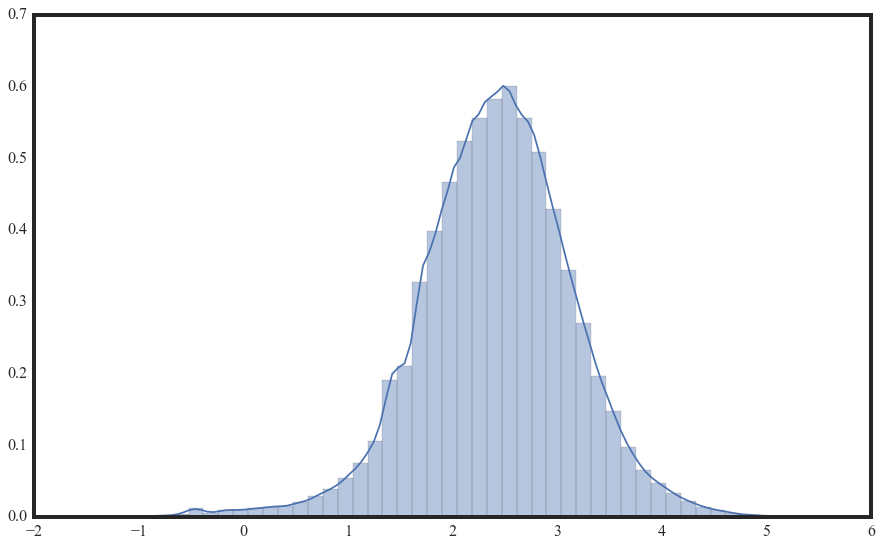

In [134]:
# Sanity Check
xy = dataUS.groupby('advertiserId')['cost'].sum().values
sns.distplot(np.log10(xy))
print np.median(xy),np.mean(xy)

In [78]:
#pick only important columns
data_clean = dataUS[['advertiserId','week', 'week_rank', 'spendAgeWeek_c', 'cost', 'employeeCount', 'isAdAgency',
                 'industry', 'type', 'source', 'salesTouched']]

In [136]:
#sanity_check : should have the same rows
print data_clean.shape, dataUS.shape

(2256794, 13) (2256794, 33)


In [79]:
# Sanity Check: Advertiser are not label twice
advertisers = data_clean.groupby(['advertiserId']).count()
advertisers_with_info = data_clean.groupby(['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched']).count() 
print 'Total advertisers:', advertisers.shape
print 'Total advertisers with labels:', advertisers_with_info.shape

Total advertisers: (224734, 10)
Total advertisers with labels: (224734, 4)


In [114]:
data_clean['first_four_weeks'] = data_clean['spendAgeWeek_c'].apply(lambda y: 1.0 if y<4 else 0.)

/Users/aristotle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [115]:
data_clean['cost_first_four_weeks'] = data_clean['first_four_weeks']*data_clean['cost']

/Users/aristotle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [137]:
#sanity_check : should have the same rows
print data_clean.shape, dataUS.shape

(2256794, 13) (2256794, 33)


In [138]:
#Aggregate data
agg_data = data_clean.groupby(['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched']).sum() 

In [140]:
agg_data.reset_index(inplace=True)

In [144]:
agg_data = agg_data[['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched', 'cost', 'cost_first_four_weeks']]

In [149]:
agg_data.head()

,advertiserId,employeeCount,isAdAgency,industry,type,source,salesTouched,cost,cost_first_four_weeks
0,2505904,1,0,Other,Direct Employer,organic,1,24.56,24.56
1,2505922,0,0,Hospitality/Travel,Direct Employer,others,0,442.49,92.28
2,2505985,1,0,Spam,Direct Employer,others,1,200.32,187.42
3,2506047,1,0,Blank,none,organic,0,11.31,11.31
4,2506048,1,0,Blank,Direct Employer,organic,0,320.82,115.98


In [146]:
cost_data = agg_data['cost'].values

270.065 1027.91784788
2.43146830388 2.41289335352
270.064999954 258.75774249


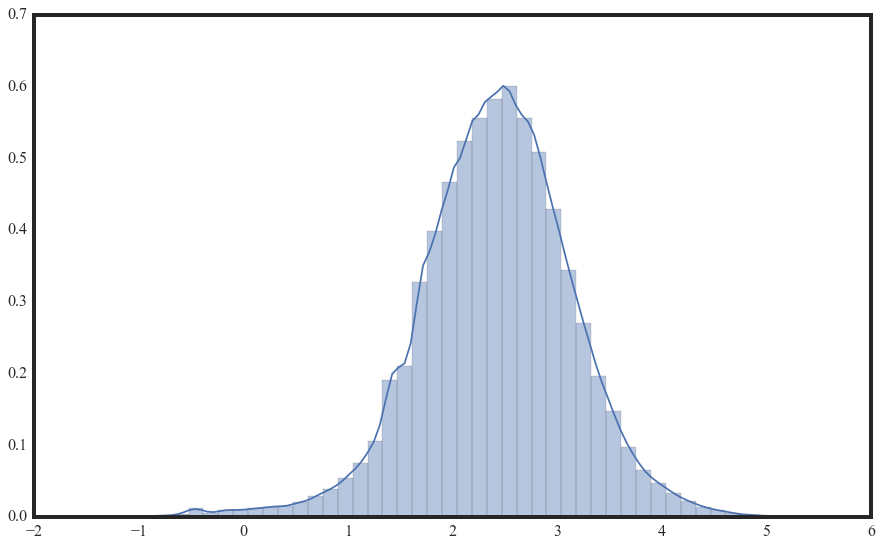

In [147]:
sns.distplot(np.log10(cost_data))
print np.median(cost_data),np.mean(cost_data)
print np.median(np.log10(cost_data)),np.mean(np.log10(cost_data))
print 10.**np.median(np.log10(cost_data)),10.**np.mean(np.log10(cost_data))

In [170]:
complete_data = dataUS[dataUS['spendAgeWeek_c']==73]

In [171]:
complete_data.shape

(1394, 33)

In [172]:
data_with_full_run = dataUS[dataUS['advertiserId'].isin(sorted(complete_data.advertiserId.unique()))]
data_with_full_run_early = data_with_full_run[data_with_full_run['spendAgeWeek_c']==0]

In [173]:
print sorted(data_with_full_run_early.week.unique())

['2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11']


In [180]:
advertiser_complete_cycle = sorted(complete_data.advertiserId.unique())

In [184]:
advertiser_incomplete_cycle = list(set(agg_data.advertiserId.unique()) - set(advertiser_complete_cycle))

In [185]:
print len(advertiser_complete_cycle), len(advertiser_incomplete_cycle)

1394 223340


### CLEAN DATA FINALLY!

In [186]:
test_data = agg_data[agg_data['advertiserId'].isin(advertiser_complete_cycle)]

In [187]:
to_be_predicted_data = agg_data[agg_data['advertiserId'].isin(advertiser_incomplete_cycle)]

In [189]:
print test_data.shape, to_be_predicted_data.shape

(1394, 9) (223340, 9)


### Important Cols
advertiserId
week
costmillicent

In [110]:
## Only consider these columns.
columns = ['employeeCount', 'isDradisEmployer', 'salesTouched', 'isAdAgency', 
'industry', 'type', 'conversionTime_c', 'hasDradisJob', 'advertiserAgeWeek_c',
'sales_touch', 'source']
print len(columns)

11


In [95]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [96]:
def remove_nans(df):
    nan_df = df[pd.isnull(df).any(axis=1)]
    for col in nan_df.columns:
        tmp = nan_df[col][pd.isnull(nan_df[col])]
        if len(tmp) >= 1:
            #print "These features have NULLs to signify the absence of such a feature:"
            print col, len(tmp)
            df[col] = df[col].fillna(0.)
    print np.shape(df)
    return df

In [97]:
## Define and remove repeat outliers
def remove_outliers(df):
    outliers  = []
    for feature in df.columns:
        
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        
        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        
        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)
        
        outliers = list(outliers + df[~((df[feature] >= Q1 - step) & \
                                                  (df[feature] <= Q3 + step))].index.tolist())
    
    # Select the indices for data points you wish to remove
    from collections import Counter
    counts = Counter(outliers)
    outliers = sorted([value for value, count in counts.items() if count > 2])
    return outliers

In [98]:
## Remove NaNs
#data_clean = remove_nans(dataUS)
#data_clean = preprocess_features(dataUS)
## Remove outliers
#outliers = remove_outliers(data)
#good_data = data_clean.drop(data_clean.index[outliers]).reset_index(drop = True)
#good_data_X = good_data.drop(['costmillicent'], axis =1)
#good_data_y =  good_data['costmillicent']
#print "The dimensions of the data without outliers now is {}".format(np.shape(good_data_X))


In [99]:
#Q1 = np.percentile(dataUS['costmillicent'], 25)
#Q3 = np.percentile(dataUS['costmillicent'], 75)
#step = 1.5*(Q3-Q1)
#outliers = list(dataUS[~((dataUS['costmillicent'] >= Q1 - step) & \
#                                                  (dataUS['costmillicent'] <= Q3 + step))].index.tolist())
#good_data = dataUS.drop(dataUS.index[outliers]).reset_index(drop = True)
#g = sns.FacetGrid(good_data, col="source")  
#g.map(sns.distplot, "costmillicent")  
#plt.xlim(0,)

In [84]:
us_clean = dataUS[dataUS.week!='2016-53']
complete_data = us_clean[us_clean['week'].isin(['2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10'])]
complete_data['cost'] = complete_data['costmillicent']
complete_data = complete_data[complete_data['isDradisEmployer']==1]

/Users/gmsardane/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [85]:
tmp = complete_data.groupby(['advertiserId'])
new_complete_data = pd.DataFrame(complete_data.groupby(['advertiserId', 'source', 'type', 'conversionTime_c',
                                                        'hasDradisJob', 'advertiserAgeWeek_c',
                                                        'isAdAgency']).agg({'cost': np.sum, 
                                                                                       'sales_touch': np.mean, 
                                                                    'advertiserId': np.count_nonzero}))
#z = complete_data.groupby(['advertiserId'])['cost'].sum()
#final = sorted(z.tolist())
#np.shape(final)
new_complete_data['CountAdvertiserID'] =  new_complete_data.advertiserId
new_complete_data = new_complete_data.drop(['advertiserId'], axis=1)
new_complete_data['mean_sales_touch'] =  new_complete_data.sales_touch
new_complete_data = new_complete_data.drop(['sales_touch'], axis=1)

grouped = new_complete_data.reset_index()
print grouped.shape
grouped.head()


(10785, 10)


,advertiserId,source,type,conversionTime_c,hasDradisJob,advertiserAgeWeek_c,isAdAgency,cost,CountAdvertiserID,mean_sales_touch
0,2505904,organic,Direct Employer,0,1,0,0,24.56,2,1.00
1,2505985,others,Direct Employer,12,1,1,0,187.42,4,0.25
2,2506048,organic,Direct Employer,0,1,0,0,183.95,6,0.00
3,2506654,direct,Direct Employer,0,1,0,0,232.65,4,0.00
4,2506768,direct,none,0,1,0,0,66.32,6,0.00


In [106]:
columns = ['employeeCount', 'isDradisEmployer', 'salesTouched', 'isAdAgency', 
'industry', 'type', 'conversionTime_c', 'hasDradisJob', 'advertiserAgeWeek_c', 'advertiserAgeWeek_c',
'sales_touch', 'source']
tmp = []
for adID in grouped.advertiserId:
    tmp.append(list(set(complete_data[complete_data.advertiserId == adID]['industry']))[0])


In [109]:
grouped['industry'] = tmp

print np.shape(grouped)
grouped.head()

(10785, 11)


,advertiserId,source,type,conversionTime_c,hasDradisJob,advertiserAgeWeek_c,isAdAgency,cost,CountAdvertiserID,mean_sales_touch,industry
0,2505904,organic,Direct Employer,0,1,0,0,24.56,2,1.00,Other
1,2505985,others,Direct Employer,12,1,1,0,187.42,4,0.25,Spam
2,2506048,organic,Direct Employer,0,1,0,0,183.95,6,0.00,NaN
3,2506654,direct,Direct Employer,0,1,0,0,232.65,4,0.00,NaN
4,2506768,direct,none,0,1,0,0,66.32,6,0.00,NaN


In [121]:
## Preprocess features with NaNs and Catgoricals
data_clean = remove_nans(grouped)
data_clean = preprocess_features(data_clean)

(10785, 11)


In [125]:
data_clean_train = data_clean.drop(['advertiserId'], axis=1)
data_clean_train_y = data_clean_train['cost']
data_clean_train_X = data_clean.drop(['cost'], axis=1)

In [179]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

def create_sets(X, y):
    # Split into training and testing components first
    
    # Set the number of training points
    num_train = int(round(0.80*len(X)))
    
    # Set the number of testing points
    num_test = X.shape[0] - num_train
    
    # Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = num_train, random_state=123458)
    
    # Show the results of the split
    print "Training set has {} samples.".format(X_train.shape[0])
    print "Testing set has {} samples.".format(X_test.shape[0])
    return X_train, X_test, y_train, y_test


In [180]:
def fit_model(X, y, n_estimators = 1000, min_samples_leaf = 1, min_samples_split =2):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20)
    regressor = GradientBoostingRegressor(loss= 'lad', n_estimators=n_estimators,min_samples_leaf = 1, 
                                          min_samples_split =2,random_state=102345)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'learning_rate': [0.01, 0.02, 0.05, 0.1], # 'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4, 5, 6], 'min_samples_leaf':  [2,3,5,7]}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring = scoring_fnc)#, verbose=10)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    # Print the optimal model after fitting the data
    print 'The cross-validation scores = {:.2f}'.format(grid.best_score_)
    print grid.best_estimator_
    return grid

In [182]:
## Train-test split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = create_sets(data_clean_train_X, np.log10(data_clean_train_y))
reg0 = fit_model(X_train, y_train)

Training set has 8628 samples.
Testing set has 2157 samples.
The cross-validation scores = 0.47
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=7, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)


NameError: name 'final' is not defined

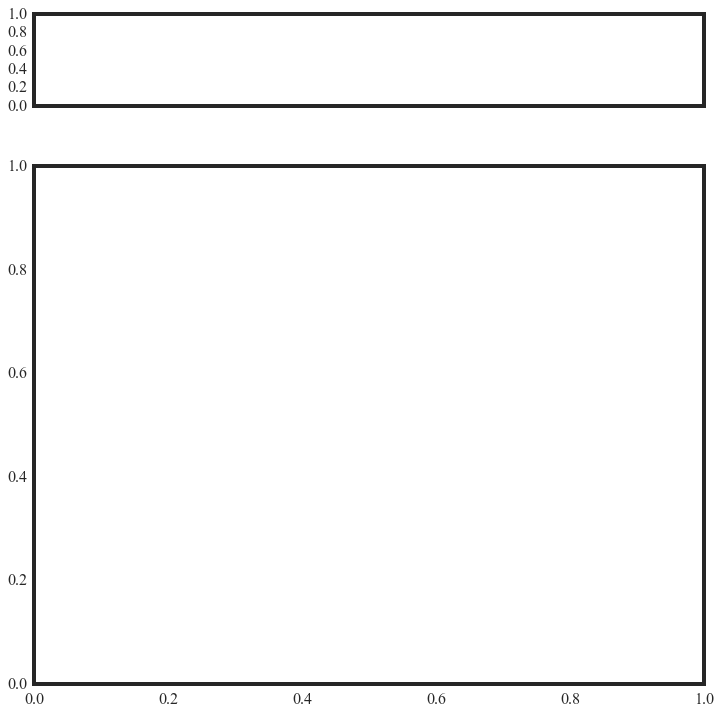

In [17]:
#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = fig_size
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(np.log10(final), ax=ax_box, color='Pink');
sns.distplot(np.log10(final), ax=ax_hist, color='grey', norm_hist=False, bins=25, hist_kws={'alpha': 0.8, 'color': 'pink'});

ax_box.set(yticks=[], xlabel='log$_{10}$ [Sale Price [USD]]')
sns.despine(ax=ax_hist);
sns.despine(ax=ax_box, left=True)

plt.xlabel('log$_{10}$ [Cost [USD]]', fontsize=35)
plt.ylabel('Counts',  fontsize=35);
#plt.xlim(1e4, 1e6);
plt.yticks(fontsize=25);
plt.xticks(fontsize=25);#, format)
#plt.semilogx();
#plt.savefig('Cost.pdf', dpi=400)

## Now I want to train these roughly 11,000 US data set that have data all throughout its lifetime. I want to predict the cost given all/any of the features.

In [ ]:
part_comp_data = complete_data[list(set(columns))]

In [ ]:
part_comp_data.head()

In [ ]:
data_clean = remove_nans(part_comp_data)
data_clean = preprocess_features(data_clean)
## Remove outliers
#outliers = remove_outliers(data)
#good_data = data_clean.drop(data_clean.index[outliers]).reset_index(drop = True)
#good_data_X = good_data.drop(['costmillicent'], axis =1)
#good_data_y =  good_data['costmillicent']
print "The dimensions of the data without outliers now is {}".format(np.shape(data_clean))
data_clean.columns

In [ ]:
len(complete_data)

In [ ]:
complete_data.columns

In [ ]:
set(complete_data.sales_touch)